This script is the codes for Seo,B.(2024), 'Econometric Forecasting Using Ubiquitous News Texts: Text-enhanced Factor Model' International Journal of Forecasting

-Last Update: 2024-11-24 <br>
-Author: Beomseok Seo (bsseo@sookmyung.ac.kr)

### 0. <font color=purple> Environment Setup

In [166]:
import os, copy, pickle, joblib, re
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
from dateutil.relativedelta import relativedelta

In [167]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
import statsmodels.api as sm
import statsmodels as sm_

In [169]:
# To display pandas in full dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [170]:
# Set criteria
def rmse(y_pred,y_true):
    return np.sqrt(np.mean((y_pred-y_true)**2))
def mae(y_pred,y_true):
    return np.mean(np.abs(y_pred-y_true))

### 1. <font color='purple'>Load Dataset

In [261]:
TODAY = '240101'

In [262]:
all_dat = pd.read_csv('./data/all_dat_YoY.csv', index_col=0)
all_grp = pd.read_csv('./data/all_grp.csv', index_col=0)
macro_feat = pd.read_csv('./data/macro_feat.csv', index_col=0)

In [264]:
all_dat.index = pd.PeriodIndex(all_dat.index, freq='M')

In [265]:
all_grp_eng = copy.deepcopy(all_grp)

In [266]:
all_grp_eng_index = \
['GDP(SA)(Q)','GDP(NSA)(Q)',
 'Private consumption(SA)(Q)', 'Government consumption(SA)(Q)', 'Construction(SA)(Q)', 'Facility investment(SA)(Q)',
 'Exports of goods and services(SA)(Q)', 'Imports of goods and services(SA)(Q)',
 'Private consumption(NSA)(Q)', 'Government consumption(NSA)(Q)', 'Construction(NSA)(Q)', 'Facility investment(NSA)(Q)',
 'Exports of goods and services(NSA)(Q)', 'Imports of goods and services(NSA)(Q)',
 'Unemployment rate', 'Employment to population ratio', 'Number of employed people',
 'Monthly goods exports','Monthly goods imports',
 'Export price index','Import price index','Producer price index','Consumer price index',
 'Price index excluding agricultural product & oil', 'Price index excluding food & energy',
 'Consumption & Retail sales index(SA)','Service industry production index(SA)',
 'Consumption & Retail sales index(NSA)','Service industry production index(NSA)',
 'Manufacturing industry production index(SA)', 'Manufacturing industry shipment index(SA)', 'Manufacturing inventory index(SA)',
 'Manufacturing industry production index(NSA)', 'Manufacturing industry shipment index(NSA)', 'Manufacturing inventory index(NSA)',
 'Facility investment index(SA)','Construction completed(SA)',
 'Facility investment index(NSA)','Construction completed(NSA)',
 'Manufacturing business performance BSI(SA)','Manufacturing business performance BSI(NSA)',
 'All industries performance BSI', 'Service industry performance BSI', 'All industries sales BSI',
 'Manufacturing export BSI', 'Manufacturing domestic demand sales BSI', 'Manufacturing new orders BSI', 'Manufacturing operation rate BSI',
 'Economic sentiment index', 'Current economic judgment CSI', 'Consumer sentiment index',
 'Consolidated fiscal balance',
 'Housing sales price index(HSPI)-Seoul', 'Housing sales price index(HSPI)-National', 'Housing lease price index(HLPI)-Seoul', 'Housing lease price index(HLPI)-National',
 'Call rate','CD rate','KTB 3-year rate','KRW exchange rate', 'EUR exchange rate', 'KOSPI', 'KOSDAQ', 
 'Dubai crude oil', 'WTI futures', 'Gold futures',
 'Production(T)','Shipbuilding(T)','Automotive(T)','Semiconductor(T)','Facility investment(T)','Construction(T)',
 'Unemployment(T)','Recruitment(T)','Job search(T)',
 'Wholesale & retail(T)', 'Government expenditure(T)','Price outlook(T)','Stock price outlook(T)','House price outlook(T)',
 'World trade(T)',
 'News sentiment index(T)','Economic policy uncertainty(T)']

In [19]:
all_grp_eng.columns = ['External','Production','Labor','Consumption','Facility Inv.','Construction','Government','Exports','Imports','Prices','Finance','Real estate','Sentiments']

In [20]:
all_dat_eng = copy.deepcopy(all_dat)
all_dat_eng.columns = all_grp_eng_index
all_grp_eng.index = all_grp_eng_index

In [21]:
all_dat = all_dat_eng
all_grp = all_grp_eng

### 2. <font color='purple'>Generate vintage data

In [33]:
macro_lag = macro_feat['LAG'].values
finan_lag = np.zeros(14)
text_lag = np.zeros(17)

all_lag = np.concatenate([macro_lag,finan_lag,text_lag])

In [34]:
test_dates = [str(x) for x in all_dat.index if str(x)>='2016-01' and int(str(x)[-2:])%3==0][:-1]

In [35]:
def _GenVintage(all_dat):
    vintage_dict = dict()
    for i in test_dates:
        temp_dat = copy.deepcopy(all_dat)
        temp_dat = temp_dat.loc[:i]    

        for j,l in enumerate(all_lag):
            if l==0:
                continue
            temp_dat.iloc[-int(l):,j] = np.nan

        vintage_dict[i] = temp_dat
    
    return vintage_dict

In [39]:
vintage_dict = _GenVintage(all_dat_P)

### 3. <font color='purple'>Experiments

#### Text-enhance Factor Model

In [42]:
factornames = {1:'External',2:'Production',3:'Labor',4:'Consumption',5:'Facility Inv.',6:'Construction',7:'Government',8:'Exports',9:'Imports',10:'Prices',11:'Finance',12:'Real estate',13:'Sentiments'}

In [43]:
factor_multiplicities = {'Global': 2}
factor_orders = {'Global': 4}

In [44]:
model_dict = dict()
results_dict = dict()

In [46]:
vintage_dict_keys = ['2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06', '2017-09', '2017-12', '2018-03', '2018-06', '2018-09', '2018-12', '2019-03', '2019-06', '2019-09', '2019-12', '2020-03', '2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12', '2022-03', '2022-06', '2022-09', '2022-12', '2023-03', '2023-06', '2023-09']

In [363]:
for trans in ['MoM','OS_MoM','NE_MoM','YoY','OS_YoY','NE_YoY']:

    all_dat_P = copy.deepcopy(all_dat)
    all_grp_P = copy.deepcopy(all_grp)

    if trans[:2] == 'NE':
        for i,x in enumerate(all_dat_P.columns):
            if x[-3:] != '(T)' and i>=14:
                all_dat_P.drop(x,axis=1, inplace=True)
                all_grp_P.drop(x,axis=0, inplace=True)

    if trans[:2] == 'OS':
        for i,x in enumerate(all_dat_P.columns):
            if x[-3:] == '(T)':
                all_dat_P.drop(x,axis=1, inplace=True)
                all_grp_P.drop(x,axis=0, inplace=True)  
                
    vitage_dict = _GenVintage(all_dat_P)
    factors = {x:['Global']+[all_grp_P.columns[i] for i,y in enumerate(all_grp_P.loc[x]) if y==1] for x in all_grp_P.index}
    
    for v in vintage_dict_keys:

        temp_dat = vintage_dict[v]

        all_dat_MON = temp_dat.iloc[:,14:]
        all_dat_MON.index = pd.PeriodIndex(all_dat_MON.index, freq='M')

        all_dat_QTR = temp_dat.iloc[:,:14]
        all_dat_QTR = all_dat_QTR.dropna()
        all_dat_QTR.index = pd.PeriodIndex(all_dat_QTR.index, freq='Q')    

        model = sm.tsa.DynamicFactorMQ(
            endog=all_dat_MON,
            endog_quarterly = all_dat_QTR,
            factors=factors, 
            factor_orders=factor_orders,
            factor_multiplicities=factor_multiplicities)
        results = model.fit(disp=True)      

        Path('./outs/out_'+trans).mkdir(parents=True, exist_ok=True)
        with open('./outs/out_'+trans+'/results_dict'+v+'.pkl', 'wb') as f:
            pickle.dump(results, f)

EM start iterations, llf=-7765.8
EM iteration 2, llf=-7461.7, convergence criterion=0.039941
EM iteration 3, llf=-7390.8, convergence criterion=0.0095472
EM iteration 4, llf=-7356.5, convergence criterion=0.0046501
EM iteration 5, llf=-7337.8, convergence criterion=0.0025506
EM iteration 6, llf=-7326.2, convergence criterion=0.0015774
EM iteration 7, llf=-7318.3, convergence criterion=0.0010865
EM iteration 8, llf=-7312.3, convergence criterion=0.00081925
EM iteration 9, llf=-7307.5, convergence criterion=0.00065746
EM iteration 10, llf=-7303.5, convergence criterion=0.00054964
EM iteration 11, llf=-7300, convergence criterion=0.00047512
EM iteration 12, llf=-7296.9, convergence criterion=0.00042338
EM iteration 13, llf=-7294.1, convergence criterion=0.00038749
EM iteration 14, llf=-7291.4, convergence criterion=0.00036334
EM iteration 15, llf=-7288.9, convergence criterion=0.00034921
EM iteration 16, llf=-7286.4, convergence criterion=0.00034509
EM iteration 17, llf=-7283.8, convergen

KeyboardInterrupt: 

#### Evaluation

In [113]:
cols_sa = ['GDP(SA)(Q)', 'Private consumption(SA)(Q)', 'Facility investment(SA)(Q)', 'Construction(SA)(Q)',
           'Exports of goods and services(SA)(Q)', 'Imports of goods and services(SA)(Q)', 'Government consumption(SA)(Q)']
cols_nsa = ['GDP(NSA)(Q)', 'Private consumption(NSA)(Q)', 'Facility investment(NSA)(Q)', 'Construction(NSA)(Q)',
            'Exports of goods and services(NSA)(Q)', 'Imports of goods and services(NSA)(Q)', 'Government consumption(NSA)(Q)']

In [114]:
results_dict_keys = ['2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06', '2017-09', '2017-12', 
                     '2018-03', '2018-06', '2018-09', '2018-12', '2019-03', '2019-06', '2019-09', '2019-12', 
                     '2020-03', '2020-06', '2020-09', '2020-12', '2021-03', '2021-06', '2021-09', '2021-12',
                     '2022-03', '2022-06', '2022-09', '2022-12', '2023-03', '2023-06', '2023-09']
next_1qa = [(dt.datetime.strptime(x, '%Y-%m')+relativedelta(months=3)).strftime('%Y-%m') for x in results_dict_keys]
next_1ma = [(dt.datetime.strptime(x, '%Y-%m')+relativedelta(months=1)).strftime('%Y-%m') for x in results_dict_keys]
next_2ma = [(dt.datetime.strptime(x, '%Y-%m')+relativedelta(months=2)).strftime('%Y-%m') for x in results_dict_keys]

In [115]:
pred_df_nsa = pd.DataFrame(columns=cols_nsa)
pred_df_sa = pd.DataFrame(columns=cols_sa)

pred1a_df_nsa = pd.DataFrame(columns=cols_nsa)
pred1a_df_sa = pd.DataFrame(columns=cols_sa)

In [117]:
for trans in ['MoM','OS_MoM','NE_MoM','YoY','OS_YoY','NE_YoY']:

    for j,v in enumerate(vintage_dict_keys):
        
        with open('./outs/out_'+trans+'/results_dict'+v+'.pkl', 'rb') as f:
            results = pickle.load(f)    
            
        time = v
        preds = results.predict(time)
        if trans[:2] == 'OS':
            preds.columns = all_grp_eng_index[14:66]+all_grp_eng_index[:14]
        elif trans[:2] == 'NE':
            preds.columns = all_grp_eng_index[66:]+all_grp_eng_index[:14]
        else:
            preds.columns = all_grp_eng_index[14:]+all_grp_eng_index[:14]
        
        time_q = pd.PeriodIndex([time], freq='Q')[0]
        temp_sa = []
        temp_sa.append(preds['GDP(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Private consumption(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Facility investment(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Construction(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Exports of goods and services(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Imports of goods and services(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Government consumption(SA)(Q)'].resample('Q').last().loc[time_q])

        temp_nsa = []
        temp_nsa.append(preds['GDP(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Private consumption(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Facility investment(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Construction(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Exports of goods and services(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Imports of goods and services(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Government consumption(NSA)(Q)'].resample('Q').last().loc[time_q])

        pred_df_nsa = pd.concat([pred_df_nsa,pd.DataFrame([temp_nsa], columns=cols_nsa, index=[time_q])],axis=0)    
        pred_df_sa = pd.concat([pred_df_sa,pd.DataFrame([temp_sa], columns=cols_sa, index=[time_q])],axis=0)

        time = next_1qa[j]    
        preds = results.predict(time)
        if trans[:2] == 'OS':
            preds.columns = all_grp_eng_index[14:66]+all_grp_eng_index[:14]
        elif trans[:2] == 'NE':
            preds.columns = all_grp_eng_index[66:]+all_grp_eng_index[:14]
        else:
            preds.columns = all_grp_eng_index[14:]+all_grp_eng_index[:14]

        time_q = pd.PeriodIndex([time], freq='Q')[0]
        temp_sa = []
        temp_sa.append(preds['GDP(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Private consumption(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Facility investment(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Construction(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Exports of goods and services(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Imports of goods and services(SA)(Q)'].resample('Q').last().loc[time_q])
        temp_sa.append(preds['Government consumption(SA)(Q)'].resample('Q').last().loc[time_q])

        temp_nsa = []
        temp_nsa.append(preds['GDP(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Private consumption(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Facility investment(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Construction(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Exports of goods and services(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Imports of goods and services(NSA)(Q)'].resample('Q').last().loc[time_q])
        temp_nsa.append(preds['Government consumption(NSA)(Q)'].resample('Q').last().loc[time_q])        

        pred1a_df_nsa = pd.concat([pred1a_df_nsa,pd.DataFrame([temp_nsa], columns=cols_nsa, index=[time_q])],axis=0)    
        pred1a_df_sa = pd.concat([pred1a_df_sa,pd.DataFrame([temp_sa], columns=cols_sa, index=[time_q])],axis=0)
        print(time)
        
#     Path("./outs/collect").mkdir(parents=True, exist_ok=True)
#     pred_df_sa.to_csv('./outs/collect/pred_df_sa_'+trans+'.csv')
#     pred_df_nsa.to_csv('./outs/collect/pred_df_nsa_'+trans+'.csv')
#     pred1a_df_sa.to_csv('./outs/collect/pred1a_df_sa_'+trans+'.csv')
#     pred1a_df_nsa.to_csv('./outs/collect/pred1a_df_nsa_'+trans+'.csv')       

#### Factor structure for TFM

In [359]:
# Latex
print(all_grp_eng.astype(str).replace('nan','').replace('1.0','V').to_latex())

\begin{tabular}{llllllllllllll}
\toprule
{} & External & Production & Labor & Consumption & Facility Inv. & Construction & Government & Exports & Imports & Prices & Finance & Real estate & Sentiments \\
\midrule
GDP(SA)(Q)                                       &          &          V &       &             &               &              &            &         &         &        &         &             &            \\
GDP(NSA)(Q)                                      &          &          V &       &             &               &              &            &         &         &        &         &             &            \\
Private consumption(SA)(Q)                       &          &            &       &           V &               &              &            &         &         &        &         &             &            \\
Government consumption(SA)(Q)                    &          &            &       &             &               &              &          V &         &         &    

#### Predictive accuracy

In [124]:
pred_dict = {}
err_dict = {}
mae_dict = {}
rmse_dict = {}

In [125]:
for sa in ['sa','nsa']:
    for fhorizon in ['pred','pred1a']:
        for trans_ in ['','_OS','_NE']:
            if sa =='sa':
                item = 'GDP(SA)(Q)'
                cols = cols_sa
                trans = '_MoM'
            else:
                item = 'GDP(NSA)(Q)'
                cols = cols_nsa
                trans = '_YoY'


            pred_df = pd.read_csv('./outs/collect/'+fhorizon+'_df_'+sa+trans_+trans+'.csv',index_col=0)
            pred_df.columns = cols
            
            pred_df = pred_df[item]
            pred_df.index = pd.PeriodIndex(pred_df.index, freq='Q')  

            true_df = all_dat.loc['201601':'202312',item].resample('M').last()

            true_df = true_df.dropna()
            true_df.index = pd.PeriodIndex(true_df.index, freq='Q')

            pred_dict[fhorizon+'_df_'+sa+trans_+trans] = pred_df
            pred_dict[fhorizon+'_df_'+sa+trans_+trans].name = fhorizon+'_df_'+sa+trans_+trans
            err_dict[fhorizon+'_df_'+sa+trans_+trans] = np.abs(pred_df-true_df)
            err_dict[fhorizon+'_df_'+sa+trans_+trans].name = fhorizon+'_df_'+sa+trans_+trans
            mae_dict[fhorizon+'_df_'+sa+trans_+trans] = np.round(np.mean(np.abs(pred_df-true_df)),3), np.round(np.std(np.abs(pred_df-true_df)),3)
            rmse_dict[fhorizon+'_df_'+sa+trans_+trans] = np.round(np.sqrt(np.mean((pred_df-true_df)**2)),3), np.round(np.std((pred_df-true_df)**2),3)

In [131]:
temp0 = pred_dict['pred_df_nsa_OS_YoY']
temp1 = pred_dict['pred_df_nsa_NE_YoY']
temp2 = pred_dict['pred_df_nsa_YoY']
true_df = all_dat.loc['201601':'202309','GDP(NSA)(Q)'].dropna()
true_df.index = pd.PeriodIndex(true_df.index, freq='Q')

In [132]:
temp_ = pd.concat([temp0,temp1, temp2, true_df],axis=1)
temp_.columns = ['Offi. Stat.', 'News Text', 'OS+NE', 'True']
plt.rcParams["figure.dpi"] = 300
temp_.plot(figsize=(10,4), color=['k','r','green','purple'], fontsize=11)
plt.legend(frameon=False)
# plt.savefig('./fig/trend_now.png',dpi=300, bbox_inches='tight')

In [133]:
temp_ = pd.concat([temp0-true_df, temp1-true_df, temp2-true_df],axis=1)
temp_.columns = ['Offi. Stat.', 'News Text', 'OS+NE']
plt.rcParams["figure.dpi"] = 300
temp_.plot(kind='bar',figsize=(10,4), width=0.8, color=['k','r','green'], fontsize=11)
plt.legend(frameon=False)
# plt.savefig('./fig/diff_now.png',dpi=300, bbox_inches='tight')

In [135]:
temp0 = pred_dict['pred1a_df_nsa_OS_YoY']
temp1 = pred_dict['pred1a_df_nsa_NE_YoY']
temp2 = pred_dict['pred1a_df_nsa_YoY']
true_df = all_dat.loc['201606':'202312','GDP(NSA)(Q)'].dropna()
true_df.index = pd.PeriodIndex(true_df.index, freq='Q')

In [136]:
temp_ = pd.concat([temp0,temp1, temp2, true_df],axis=1)
temp_.columns = ['Offi. Stat.', 'News Text', 'OS+NE', 'True']
plt.rcParams["figure.dpi"] = 300
temp_.plot(figsize=(10,4), color=['k','r','green','purple'], fontsize=11)
plt.legend(frameon=False)
# plt.savefig('./fig/trend_1qa.png',dpi=300, bbox_inches='tight')

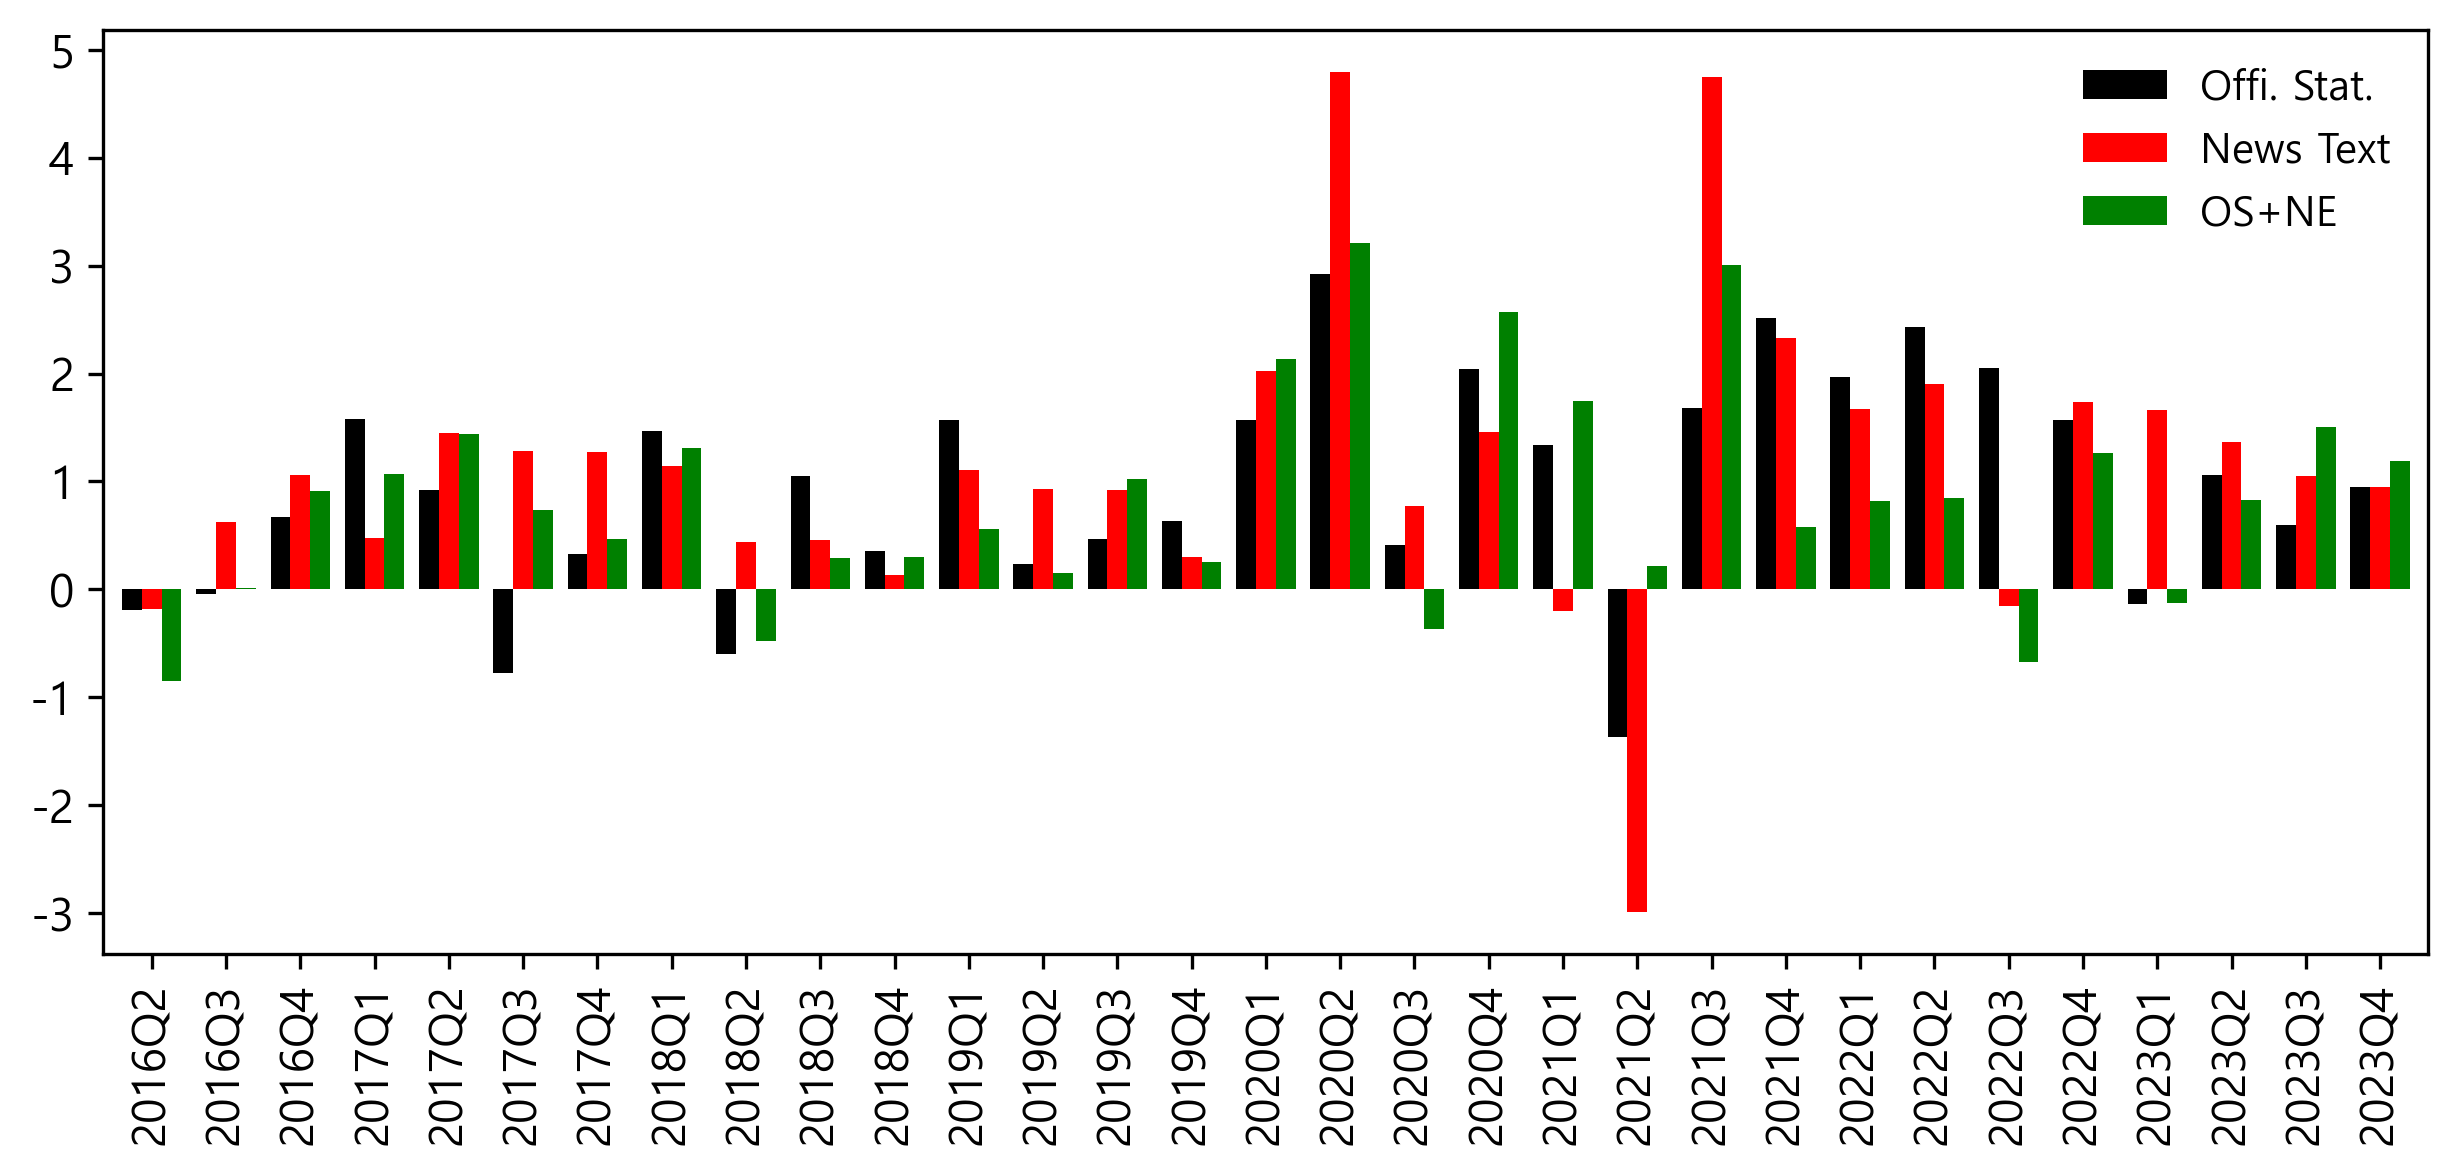

In [137]:
temp_ = pd.concat([temp0-true_df, temp1-true_df, temp2-true_df],axis=1)
temp_.columns = ['Offi. Stat.', 'News Text', 'OS+NE']
plt.rcParams["figure.dpi"] = 300
temp_.plot(kind='bar',figsize=(10,4), width=0.8, color=['k','r','green'], fontsize=11)
plt.legend(frameon=False)
# plt.savefig('./fig/diff_1qa.png',dpi=300, bbox_inches='tight')    

#### Event study during covid
   

In [160]:
k='2020-03'

In [161]:
with open('./outs/out_YoY/results_dict'+k+'.pkl', 'rb') as f:
    results = pickle.load(f)
with open('./outs/out_OS_YoY/results_dict'+k+'.pkl', 'rb') as f:
    results_m = pickle.load(f)        

In [164]:
startmon = '2019-01'

prediction_results = results.get_prediction(start=startmon, end='2022')
prediction_results_m = results_m.get_prediction(start=startmon, end='2022')

variables = ['GDP(NSA)(Q)']

point_predictions = prediction_results.predicted_mean
point_predictions.columns = all_grp_eng_index[14:]+all_grp_eng_index[:14]
point_predictions = point_predictions[variables]

point_predictions_m = prediction_results_m.predicted_mean
point_predictions_m.columns = all_grp_eng_index[14:66]+all_grp_eng_index[:14]
point_predictions_m = point_predictions_m[variables]

variables = ['GDP(NSA)(Q)']

ci = prediction_results.conf_int(alpha=0.05)
ci.columns = [f'lower {name}' for name in all_grp_eng_index[14:]+all_grp_eng_index[:14]]+\
             [f'upper {name}' for name in all_grp_eng_index[14:]+all_grp_eng_index[:14]]
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

ci_m = prediction_results_m.conf_int(alpha=0.05)
ci_m.columns = [f'lower {name}' for name in all_grp_eng_index[14:66]+all_grp_eng_index[:14]]+\
               [f'upper {name}' for name in all_grp_eng_index[14:66]+all_grp_eng_index[:14]]
lower_m = ci_m[[f'lower {name}' for name in variables]]
upper_m = ci_m[[f'upper {name}' for name in variables]]


with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(10, 4))

    point_predictions.loc[:'2022-01'].plot(ax=ax)
    point_predictions_m.loc[:'2022-01'].plot(ax=ax)

    point_predictions.loc['2022-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)
    point_predictions_m.loc['2022-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    for i, name in enumerate(variables):
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], 
                        alpha=0.2)
        ax.fill_between(ci_m.index,
                        lower_m[f'lower {name}'],
                        upper_m[f'upper {name}'], 
                        alpha=0.2)

    ax.set_ylim((-6,9))
    ylim = ax.get_ylim()
    ax.vlines('2020-03', ylim[0], ylim[1], linewidth=1, color='k', linestyle='--')
    ax.vlines('2022-03', ylim[0], ylim[1], linewidth=1, color='r', linestyle='--')
    ax.annotate(r'Forecast $\rightarrow$', ('2020-04', -5.5),backgroundcolor='w')
    plt.annotate(r' 2022.Q1', ('2022-04', -7.7), color='r')
    ax.set(ylim=ylim)
    
    s1 = all_dat[variables[0]][startmon:'2022-01']
    s1mask = np.isfinite(s1)
    s1[s1mask].plot(ax=ax, label='', legend=True, linewidth=1, linestyle='-.', color='C2')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    h,l = ax.get_legend_handles_labels()
    ax.legend([x for i,x in enumerate(h) if i in [0,1,2]], ['Predicted by OS+NE','Predicted by Offi. Stat.', 'GDP(NSA) YoY'], loc='lower left',
              frameon=False,
              fontsize=13)
    fig.tight_layout()
#     plt.savefig('./fig/covid.png',dpi=300)

#### The coefficient of determination, R2

In [226]:
plt.rcParams['text.usetex'] = False

In [227]:
k = '2020-03'

In [228]:
with open('./outs/out_YoY/results_dict'+k+'.pkl', 'rb') as f:
    results = pickle.load(f)

In [229]:
rsquared = results.get_coefficients_of_determination(method='individual')
new_cols = ['Overall-1','Overall-2','Production', 'Consumption', 'Government', 'Construction', 'Facility Inv.',
            'External', 'Exports', 'Imports', 'Labor', 'Prices', 'Sentiments', 'Real estate', 'Finance']

In [230]:
rsquared.index = np.concatenate([all_grp_eng.index[14:],all_grp_eng.index[:14]])
rsquared.index = [x.replace('&','') for x in rsquared.index]
rsquared.columns = new_cols

In [231]:
with sns.color_palette('deep'):
    
    fig, ax = plt.subplots(figsize=(15, 7))

    ax.set_ylim(0, 0.8)
    var = rsquared.index
    value = rsquared['Overall-1']
    
    newsvarid = [i for i,x in enumerate(var) if x[-3:]=='(T)']
    colvar = np.array(['tab:orange' for x in var])
    coltext = np.array(['black' for x in var])
    colvar[newsvarid] = 'blue'
    coltext[newsvarid] = 'blue'
    
    value.plot(ax=ax, kind='bar', color=colvar)    

    ax.annotate(r'The coefficient of determination, $R^2$, of the first overall factor to each variable.', (len(var) / 2, 0.75), ha='center', va='top', rotation=0)

    ax.set_xticklabels(var)
    for xtick, color in zip(ax.get_xticklabels(), coltext):
        xtick.set_color(color)        
 
    plt.tight_layout()
#     plt.savefig('./fig/covid_rsquared_overall-1.png',dpi=300)

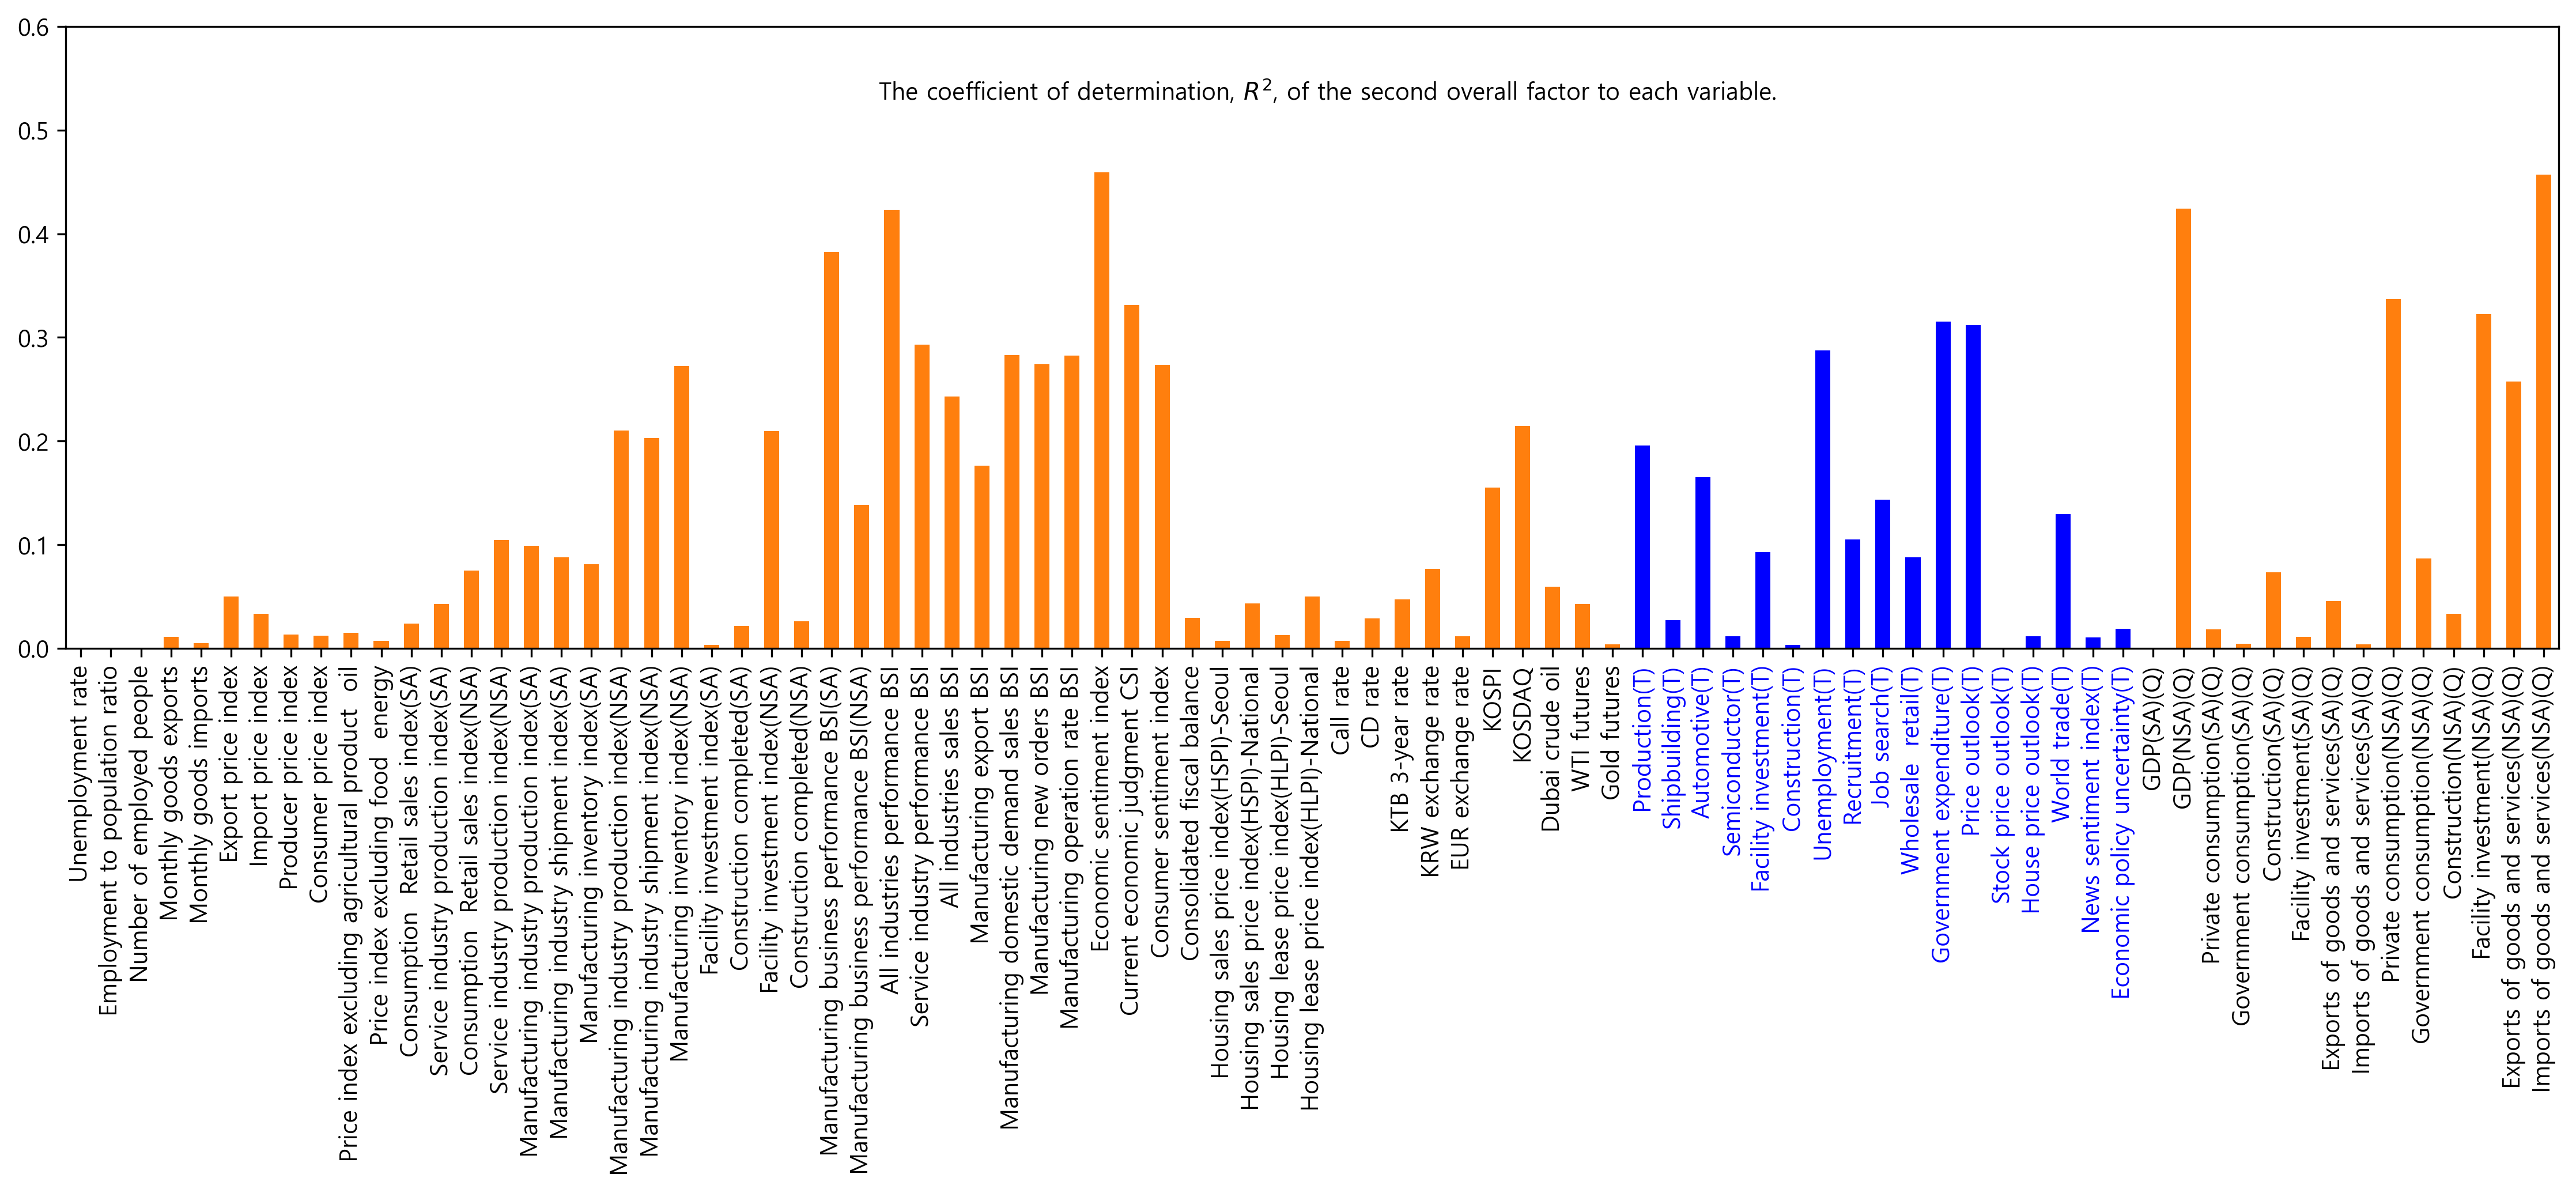

In [232]:
with sns.color_palette('deep'):
    
    fig, ax = plt.subplots(figsize=(15, 7))

    ax.set_ylim(0, 0.6)
    var = rsquared.index
    value = rsquared['Overall-2']
    
    newsvarid = [i for i,x in enumerate(var) if x[-3:]=='(T)']
    colvar = np.array(['tab:orange' for x in var])
    coltext = np.array(['black' for x in var])
    colvar[newsvarid] = 'blue'
    coltext[newsvarid] = 'blue'
    
    value.plot(ax=ax, kind='bar', color=colvar)    

    ax.annotate('The coefficient of determination, $R^2$, of the second overall factor to each variable.', (len(var) / 2, 0.55), ha='center', va='top', rotation=0)

    ax.set_xticklabels(var)
    for xtick, color in zip(ax.get_xticklabels(), coltext):
        xtick.set_color(color)        
          
    plt.tight_layout()
#     plt.savefig('./fig/covid_rsquared_overall-2.png',dpi=300)

In [233]:
var = []
value = []
group = []
for c in rsquared.iloc[:,2:].columns:
    var.append(rsquared[c].dropna().index)
    value.append(rsquared[c].dropna())
    group.append(len(rsquared[c].dropna()))

In [234]:
var = pd.Series([x for y in var for x in y])
value = pd.Series([x for y in value for x in y])

In [235]:
group_counts = pd.Series(group).cumsum()

In [236]:
newsvarid = [i for i,x in enumerate(var) if x[-3:]=='(T)']
colvar = np.array(['tab:orange' for x in var])
coltext = np.array(['black' for x in var])
colvar[newsvarid] = 'blue'
coltext[newsvarid] = 'blue'

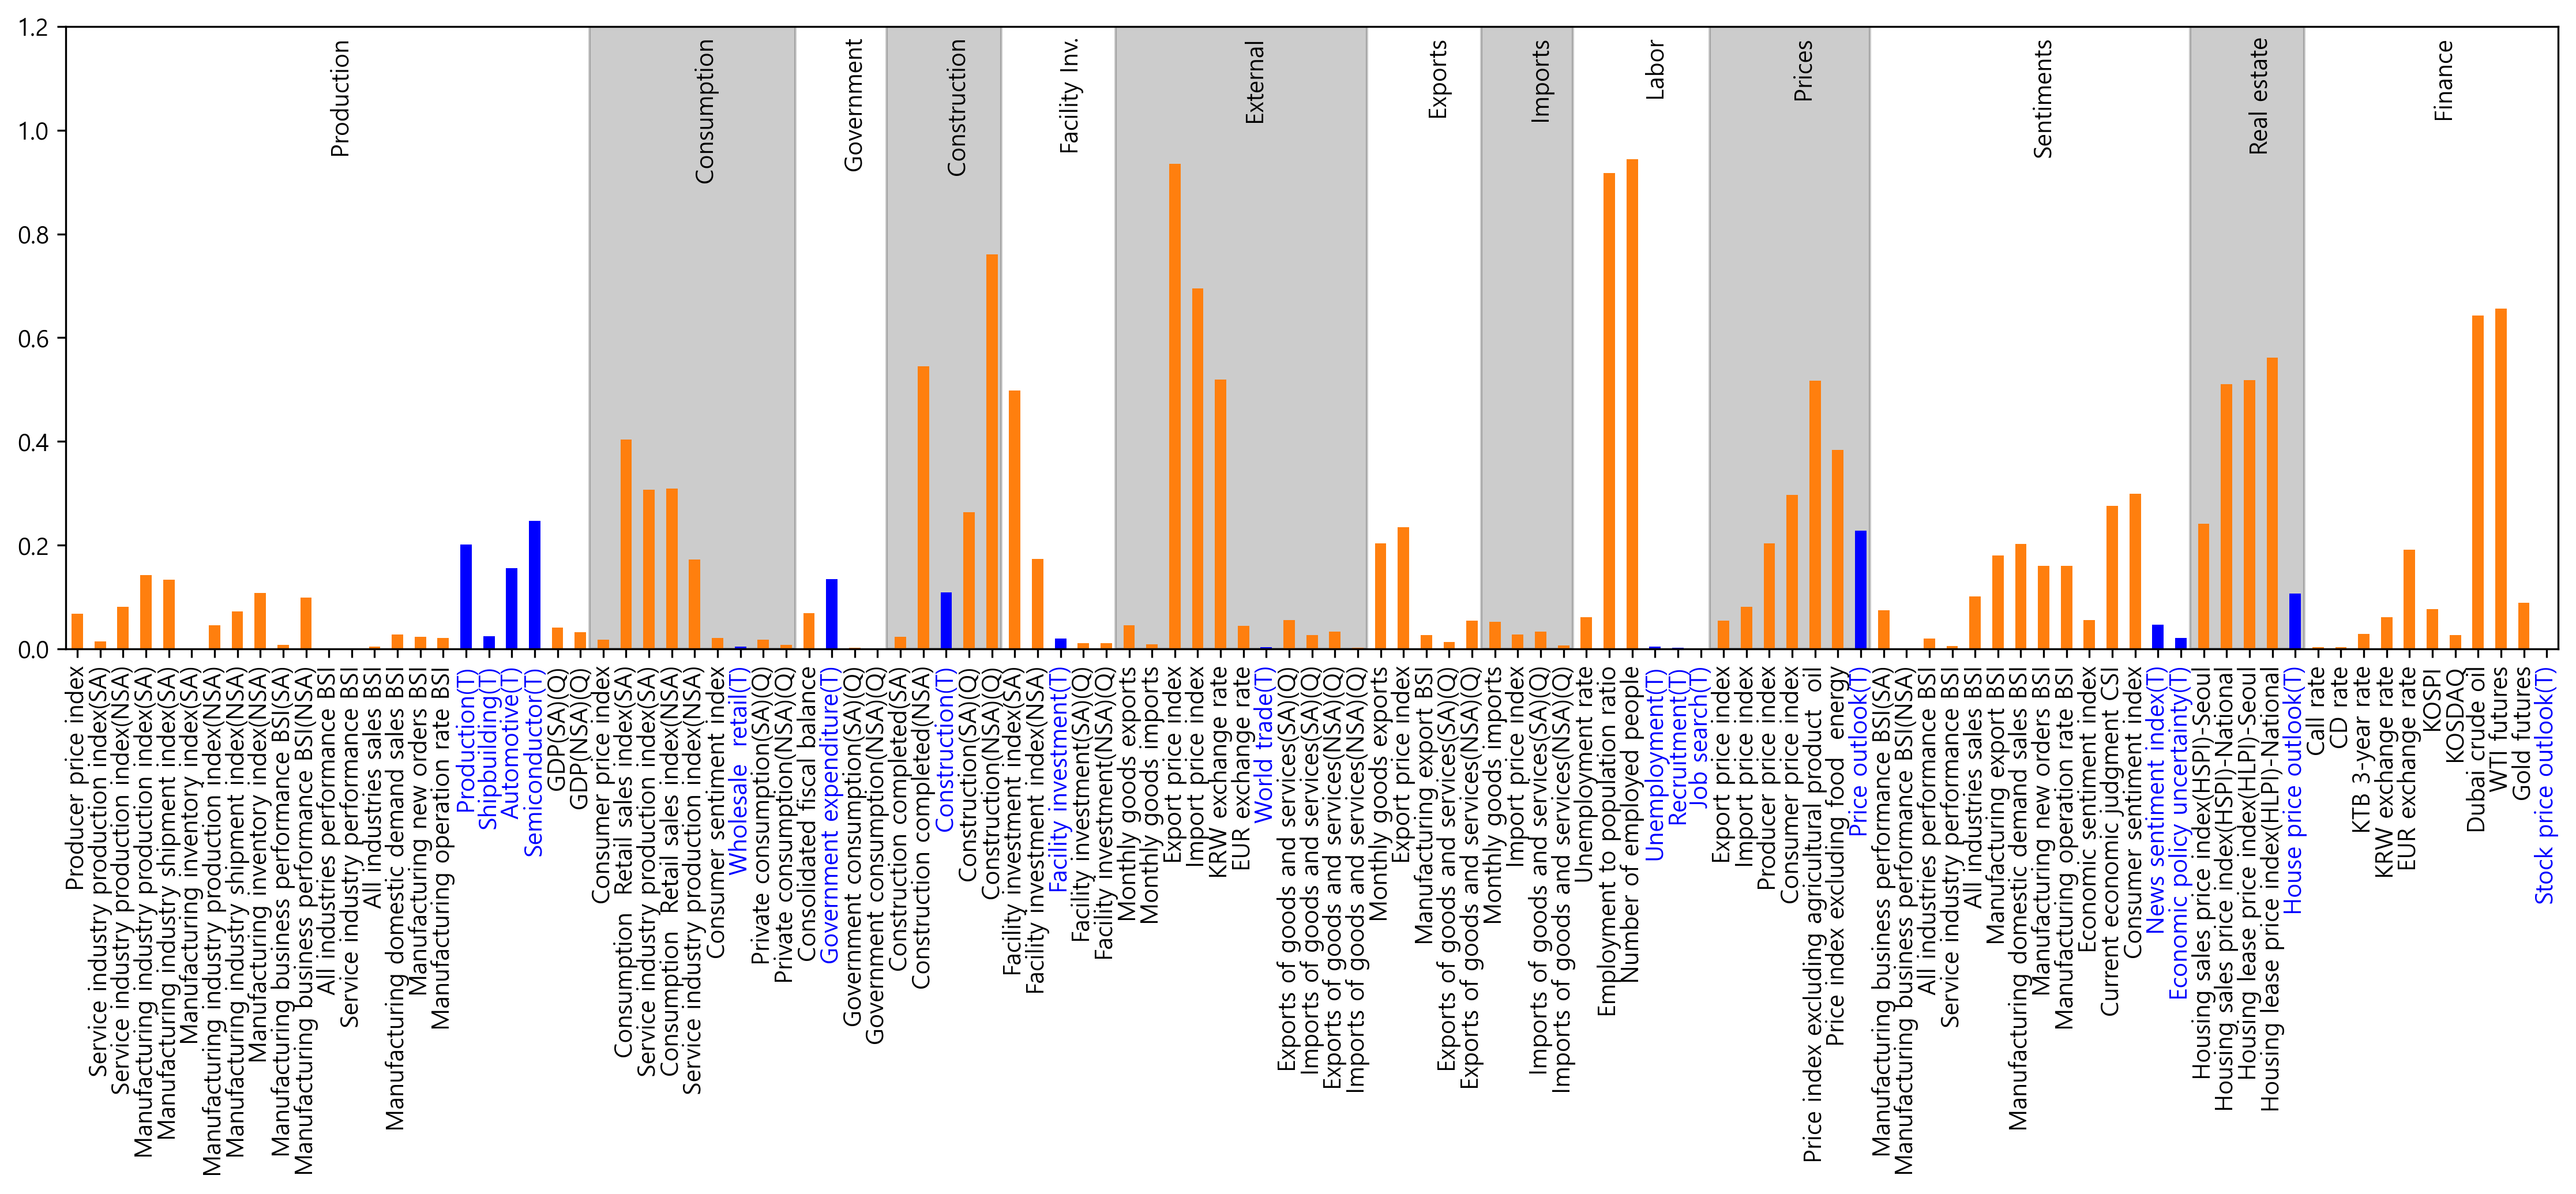

In [237]:
with sns.color_palette('deep'):
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    ax.set_xlim(-1, len(var)+1)
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.2)
        
    value.plot(ax=ax, kind='bar', color=colvar)    
        
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i]
        n = end - start
        text = rsquared.iloc[:,2:].columns[i]

        ax.annotate(text, (start + n / 2, 1.18), ha='center', va='top', rotation=90)

    ax.set_xticklabels(var)
    for xtick, color in zip(ax.get_xticklabels(), coltext):
        xtick.set_color(color)        
        
    plt.tight_layout()
#     plt.savefig('./fig/covid_rsquared.png',dpi=300)

---

##### Table 2. All variables and factors for Text-enhanced Factor Model.

In [339]:
# Latex
print(all_grp_eng.astype(str).replace('nan','').replace('1.0','V').to_latex())

\begin{tabular}{llllllllllllll}
\toprule
{} & External & Production & Labor & Consumption & Facility Inv. & Construction & Government & Exports & Imports & Prices & Finance & Real estate & Sentiments \\
\midrule
GDP(SA)(Q)                                       &          &          V &       &             &               &              &            &         &         &        &         &             &            \\
GDP(NSA)(Q)                                      &          &          V &       &             &               &              &            &         &         &        &         &             &            \\
Private consumption(SA)(Q)                       &          &            &       &           V &               &              &            &         &         &        &         &             &            \\
Government consumption(SA)(Q)                    &          &            &       &             &               &              &          V &         &         &    

#### Predictive accuracy for monthly variables.

In [335]:
all_grp_kor_index = ['GDP(SA)', 'GDP(불변)', '민간소비(SA)', '정부소비(SA)', '건설투자(SA)', '설비투자(SA)',
       '국민계정_수출(SA)', '국민계정_수입(SA)', '민간소비(불변)', '정부소비(불변)', '건설투자(불변)',
       '설비투자(불변)', '국민계정_수출(불변)', '국민계정_수입(불변)', '실업률', '고용률', '취업자', '수출',
       '수입', '수출물가지수', '수입물가지수', '생산자물가지수', '소비자물가지수', '농산물및석유류제외지수',
       '식료품및에너지제외지수', '소매판매액지수(SA)', '서비스업생산지수(SA)', '소매판매액지수(불변)',
       '서비스업생산지수(불변)', '제조업생산지수(SA)', '제조업출하지수(SA)', '제조업재고지수(SA)',
       '제조업생산지수(불변)', '제조업출하지수(불변)', '제조업재고지수(불변)', '설비투자지수(SA)', '건설기성액(SA)',
       '설비투자지수(불변)', '건설기성액(불변)', '제조업업황실적BSI(SA)', '제조업업황실적BSI(불변)',
       '전산업업황실적BSI', '서비스업업황실적BSI', '전산업매출실적BSI', '제조업수출실적BSI', '제조업내수판매실적BSI',
       '제조업신규수주실적BSI', '제조업가동률실적BSI', '경제심리지수', '현재경기판단CSI', '소비자심리지수',
       '통합재정수지', '주택매매가격지수_서울', '주택매매가격지수_전국', '주택전세가격지수_서울', '주택전세가격지수_전국',
       '콜금리', 'CD금리', '국고채3년', '원달러환율', '달러유로환율', 'KOSPI', 'KOSDAQ', '두바이현물',
       'WTI선물', '금현물', '(텍스트)생산', '(텍스트)선박', '(텍스트)자동차', '(텍스트)반도체',
       '(텍스트)설비투자', '(텍스트)건설투자', '(텍스트)실업', '(텍스트)채용', '(텍스트)구직', '(텍스트)도소매',
       '(텍스트)정부지출', '(텍스트)물가전망', '(텍스트)주가전망', '(텍스트)주택가격전망', '(텍스트)세계교역',
       '(텍스트)뉴스심리지수', '(텍스트)경제불확실성지수']

In [349]:
cols0_kor = ['실업률', '고용률', '소비자물가지수', '농산물및석유류제외지수', '식료품및에너지제외지수', '제조업생산지수(SA)', '서비스업생산지수(SA)', '설비투자지수(SA)', '건설기성액(SA)', '통합재정수지', '경제심리지수', '주택매매가격지수_전국']
cols1_kor = ['실업률','소비자물가지수','제조업생산지수(SA)','서비스업생산지수(SA)','설비투자지수(SA)','건설기성액(SA)','주택매매가격지수_전국']

In [350]:
cols0 = [all_grp.index[np.where(np.array(all_grp_kor_index)==x)[0][0]] for x in cols0_kor]
cols1 = [all_grp.index[np.where(np.array(all_grp_kor_index)==x)[0][0]] for x in cols1_kor]

In [351]:
with open('./outs/pred_df_month_out_YoY.pkl','rb') as f:
    pred_df_osne = pickle.load(f)
with open('./outs/pred_df_month_out_OS_YoY.pkl','rb') as f:
    pred_df_os = pickle.load(f)    

In [352]:
true_df_sa_all = dict()

In [353]:
s = 0
for k in range(3):
    true_df_sa = pd.DataFrame(columns=cols1)
    for j,i in enumerate(results_dict_keys[s:]):
        time_ = [results_dict_keys[s:][j], next_1ma[s:][j], next_2ma[s:][j]]
        time = time_[k]

        time_m = pd.PeriodIndex([time], freq='M')[0]
        true_sa = []

        for cc in cols1:
            true_sa.append(all_dat.loc[time,cc])
        true_df_sa = pd.concat([true_df_sa,pd.DataFrame([true_sa], columns=cols1, index=[time_m])],axis=0)

    true_df_sa_all[k] = true_df_sa

In [354]:
def paren(x): return '('+str(np.round(x,3))+')'
def noparen(x): return str(np.round(x,3))

In [355]:
def comp_latex(i):
    
    pred_df_os_ = pred_df_os[i]
    pred_df_osne_ = pred_df_osne[i]
    
    pred_df_os_.columns = cols0
    pred_df_osne_.columns = cols0
    
    os_a = np.mean(np.abs(pred_df_os_-true_df_sa_all[i]),axis=0)
    os_b = np.std(np.abs(pred_df_os_-true_df_sa_all[i]),axis=0)
    os_b.index = [x+'_std' for x in os_b.index]

    h_a = np.mean(np.abs(pred_df_osne_-true_df_sa_all[i]),axis=0)
    h_b = np.std(np.abs(pred_df_osne_-true_df_sa_all[i]),axis=0)
    h_b.index = [x+'_std' for x in h_b.index]

    ind = [y for x in [[x,x+'_std'] for x in cols] for y in x] 


    return pd.concat([ \
            pd.concat([os_a.map(noparen),os_b.map(paren)],axis=0)[ind],\
            pd.concat([h_a.map(noparen),h_b.map(paren)],axis=0)[ind]\
                      ],axis=1)

In [356]:
c0 = comp_latex(0)
c1 = comp_latex(1)
c2 = comp_latex(2)

In [357]:
cc = pd.concat([c0,c1,c2],axis=1)
cc.index = ['Unemployment rate','','Cosummer price index','','Manufacturing production ind.(SA)','',
           'Service industry prod. ind.(SA)','','Facility investment ind.(SA)','',
           'Construction completed(SA)','','Housing sales price ind.-Nat.','']

In [358]:
print(cc.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &        0 &        1 &        0 &        1 &        0 &        1 \\
\midrule
Unemployment rate                 &    3.436 &    3.408 &    4.378 &    4.314 &    5.861 &    5.884 \\
                                  &  (2.855) &  (2.838) &  (2.779) &   (2.85) &  (4.598) &  (4.642) \\
Cosummer price index              &    0.173 &    0.169 &    0.235 &    0.203 &    0.243 &    0.239 \\
                                  &  (0.129) &  (0.126) &  (0.156) &  (0.159) &  (0.165) &  (0.201) \\
Manufacturing production ind.(SA) &    2.315 &     2.22 &    1.712 &    1.753 &     2.06 &    2.037 \\
                                  &  (2.207) &  (1.762) &  (1.372) &   (1.21) &  (1.625) &  (1.498) \\
Service industry prod. ind.(SA)   &    0.737 &    0.772 &    0.667 &     0.73 &    0.885 &    0.904 \\
                                  &  (0.973) &  (1.048) &  (0.646) &  (0.562) &  (0.813) &  (0.828) \\
Facility investment ind.(SA)      &    3.786 &    3.613 &    

#### Predictive MAE and RMSE

In [239]:
true_qtr = ['2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4']
true_val = [0.3, 1.2, 0.4, 0.6, 1, 0.8, 1.4, -0.3, 1.3, 0.7, 0.6, 0.6, -0.1, 1.1, 0.4, 1.2, -1.3, -3, 2.3, 1.3, 1.8, 0.9, 0.1, 1.4, 0.7, 0.8, 0.2, -0.3, 0.3, 0.6, 0.6, 0.6]

In [78]:
# pred_df = pred_df_sa[item]

In [91]:
pred_dict = {}
err_dict = {}
mae_dict = {}
rmse_dict = {}

In [92]:
trans_list = ['YoY','bYoY','MoM','bMoM','OS','NE']
fhorizon_list = ['pred','pred1a']
sa_list = ['sa','nsa']

In [243]:
for sa in ['sa','nsa']:
    for fhorizon in ['pred','pred1a']:
        for trans_ in ['','_OS','_NE']:
            if sa =='sa':
                item = 'GDP(SA)(Q)'
                cols = cols_sa
                trans = '_MoM'
            else:
                item = 'GDP(NSA)(Q)'
                cols = cols_nsa
                trans = '_YoY'


            pred_df = pd.read_csv('./outs/collect/'+fhorizon+'_df_'+sa+trans_+trans+'.csv',index_col=0)
            pred_df.columns = cols
            pred_df = pred_df[item]
            pred_df.index = pd.PeriodIndex(pred_df.index, freq='Q')  

            true_df = all_dat.loc['201601':'202312',item].resample('M').last()

            true_df = true_df.dropna()
            true_df.index = pd.PeriodIndex(true_df.index, freq='Q')

            pred_dict[fhorizon+'_df_'+sa+trans_+trans] = pred_df
            pred_dict[fhorizon+'_df_'+sa+trans_+trans].name = fhorizon+'_df_'+sa+trans_+trans
            err_dict[fhorizon+'_df_'+sa+trans_+trans] = np.abs(pred_df-true_df)
            err_dict[fhorizon+'_df_'+sa+trans_+trans].name = fhorizon+'_df_'+sa+trans_+trans
            mae_dict[fhorizon+'_df_'+sa+trans_+trans] = np.round(np.mean(np.abs(pred_df-true_df)),3), np.round(np.std(np.abs(pred_df-true_df),ddof=1),3)
            rmse_dict[fhorizon+'_df_'+sa+trans_+trans] = np.round(np.sqrt(np.mean((pred_df-true_df)**2)),3), np.round(np.std((pred_df-true_df)**2,ddof=1),3)

In [244]:
mae_dict

{'pred_df_sa_MoM': (0.448, 0.415),
 'pred_df_sa_OS_MoM': (0.46, 0.415),
 'pred_df_sa_NE_MoM': (0.563, 0.558),
 'pred1a_df_sa_MoM': (0.657, 0.686),
 'pred1a_df_sa_OS_MoM': (0.653, 0.643),
 'pred1a_df_sa_NE_MoM': (0.619, 0.614),
 'pred_df_nsa_YoY': (0.723, 0.673),
 'pred_df_nsa_OS_YoY': (0.836, 0.735),
 'pred_df_nsa_NE_YoY': (0.992, 0.838),
 'pred1a_df_nsa_YoY': (0.997, 0.818),
 'pred1a_df_nsa_OS_YoY': (1.145, 0.77),
 'pred1a_df_nsa_NE_YoY': (1.341, 1.14)}

In [245]:
rmse_dict

{'pred_df_sa_MoM': (0.606, 0.583),
 'pred_df_sa_OS_MoM': (0.615, 0.618),
 'pred_df_sa_NE_MoM': (0.787, 1.204),
 'pred1a_df_sa_MoM': (0.942, 1.731),
 'pred1a_df_sa_OS_MoM': (0.909, 1.686),
 'pred1a_df_sa_NE_MoM': (0.865, 1.534),
 'pred_df_nsa_YoY': (0.98, 1.697),
 'pred_df_nsa_OS_YoY': (1.106, 1.947),
 'pred_df_nsa_NE_YoY': (1.29, 2.715),
 'pred1a_df_nsa_YoY': (1.281, 2.58),
 'pred1a_df_nsa_OS_YoY': (1.373, 2.137),
 'pred1a_df_nsa_NE_YoY': (1.748, 5.589)}

#### The variables affecting the GDP(NSA) forecasts for the first and second quarters of 2020

In [246]:
vintage_results = dict()

for k in ['2019-12','2020-03','2020-06']:
    with open('./outs/out_YoY/results_dict'+k+'.pkl', 'rb') as f:
        vintage_results[k] = pickle.load(f)
    print(k)

2019-12
2020-03
2020-06


In [287]:
news = vintage_results['2020-03'].news(vintage_results['2019-12'], 
                                impact_date='2020-03',
                                impacted_variable='GDP(불변)',
                                comparison_type='previous'
                               )

In [288]:
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))

In [289]:
all_grp_eng_index_sorted = all_grp_eng_index[:-17]+all_grp_eng_index[-2:]+all_grp_eng_index[-17:-2]
details_index = list(details.index)
details_index_name = details.index.name

In [291]:
for i,v in enumerate(details.index):
    j = np.where([x==v[1] for x in all_grp_kor_index])[0][0]
    details_index[i] = (details.index[i][0], all_grp_eng_index_sorted[j])

In [292]:
details.index = pd.MultiIndex.from_tuples(details_index)
details_index_new = []
for i,x in enumerate(details.index):
    details_index_new.append((details.index[i][0],details.index[i][1].replace('Manufacturing','Manufact.').replace('industry','ind.').replace(' index','')))

In [293]:
details.index = pd.MultiIndex.from_tuples(details_index_new)
details.index.name=details_index_name

In [294]:
details.iloc[:10].round(2)

observed  forecast (prev)   news  \
2020-01 Manufact. ind. shipment(NSA)       -6.89             2.72  -9.61   
        Manufact. ind. production(NSA)     -4.62             3.77  -8.39   
        Manufact. ind. shipment(SA)        -4.06             0.33  -4.39   
2020-02 Manufact. ind. shipment(SA)        -4.30             0.51  -4.82   
2019-12 Manufact. ind. shipment(NSA)        5.67             1.37   4.30   
2020-01 Manufact. ind. production(SA)      -3.62             0.59  -4.21   
2020-02 Manufact. ind. production(NSA)     10.01             5.23   4.78   
        All industries performance BSI    -10.92             1.31 -12.23   
        Manufact. ind. production(SA)      -3.78             0.53  -4.31   
2019-12 Manufact. ind. production(NSA)      7.30             1.80   5.51   

                                        weight  impact  
2020-01 Manufact. ind. shipment(NSA)      0.03   -0.27  
        Manufact. ind. production(NSA)    0.02   -0.16  
        Manufact. ind. shipment(SA)       0.03   -0.12  
2020-02 Manufact. ind. shipment(SA)       0.02   -0.10  
2019-12 Manufact. ind. shipment(NSA)      0.02    0.09  
2020-01 Manufact. ind. production(SA)     0.02   -0.09  
2020-02 Manufact. ind. production(NSA)    0.02    0.09  
        All industries performance BSI   -0.01    0.08  
        Manufact. ind. production(SA)     0.02   -0.08  
2019-12 Manufact. ind. production(NSA)    0.01    0.07

In [295]:
print(details.iloc[:10].round(2).to_latex())

\begin{tabular}{llrrrrr}
\toprule
        &                                &  observed &  forecast (prev) &   news &  weight &  impact \\
\midrule
2020-01 & Manufact. ind. shipment(NSA) &     -6.89 &             2.72 &  -9.61 &    0.03 &   -0.27 \\
        & Manufact. ind. production(NSA) &     -4.62 &             3.77 &  -8.39 &    0.02 &   -0.16 \\
        & Manufact. ind. shipment(SA) &     -4.06 &             0.33 &  -4.39 &    0.03 &   -0.12 \\
2020-02 & Manufact. ind. shipment(SA) &     -4.30 &             0.51 &  -4.82 &    0.02 &   -0.10 \\
2019-12 & Manufact. ind. shipment(NSA) &      5.67 &             1.37 &   4.30 &    0.02 &    0.09 \\
2020-01 & Manufact. ind. production(SA) &     -3.62 &             0.59 &  -4.21 &    0.02 &   -0.09 \\
2020-02 & Manufact. ind. production(NSA) &     10.01 &             5.23 &   4.78 &    0.02 &    0.09 \\
        & All industries performance BSI &    -10.92 &             1.31 & -12.23 &   -0.01 &    0.08 \\
        & Manufact. ind. product